## ***`How to interpret the model behavior?`***

---
#### ***The objective for creating this notebook is to understand and work with various `Model Agnostic(means model independent)` techniques for interpretating the models behavior or prediction. Also, what are their advantages and disadvantages.***
---

#### **Notebook Contents**

1. [Library Import](#Packages_Import)
2. [Load Dataset](#Dataset_Creation)
3. [Models Instantiation](#Models_Instantiation)

#### **Packages_Import**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import shap
import lime
import eli5

from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

pd.set_option('display.max_columns',50)

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


#### **Dataset_Creation**

In [2]:
lbc = load_breast_cancer()
ld = load_diabetes()

In [3]:
X_cancer = pd.DataFrame(lbc.data,columns=lbc.feature_names)
y_cancer = pd.DataFrame(lbc.target,columns=['Label'])

In [4]:
X_diab = pd.DataFrame(ld.data,columns=ld.feature_names)
y_diab = pd.DataFrame(ld.target,columns=['Label'])

In [5]:
X_cancer.shape, y_cancer.shape, X_diab.shape, y_diab.shape

((569, 30), (569, 1), (442, 10), (442, 1))

In [6]:
X_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
pd.DataFrame(y_cancer.value_counts())

,0
Label,
1,357
0,212


In [8]:
X_diab.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


#### **Train and Test sets creation for Cancer Dataset**

In [44]:
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer,y_cancer,
                                                                                test_size=0.33,
                                                                                stratify=y_cancer,
                                                                                random_state=41)

In [45]:
X_train_cancer = pd.DataFrame(X_train_cancer,columns=lbc.feature_names)
X_test_cancer = pd.DataFrame(X_test_cancer,columns=lbc.feature_names)

In [46]:
X_train_cancer.shape, X_test_cancer.shape, y_train_cancer.shape, y_test_cancer.shape

((381, 30), (188, 30), (381, 1), (188, 1))

#### **Train and Test sets creation for Diabetes Dataset**

In [47]:
X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(X_diab,y_diab,
                                                                                test_size=0.2,
                                                                                random_state=11)

In [48]:
X_train_diab = pd.DataFrame(X_train_diab,columns=ld.feature_names)
X_test_diab = pd.DataFrame(X_test_diab,columns=ld.feature_names)

In [49]:
X_train_diab.shape, X_test_diab.shape, y_train_diab.shape, y_test_diab.shape

((353, 10), (89, 10), (353, 1), (89, 1))

#### **Models_Instantiation**

In [102]:
dtc = DecisionTreeClassifier(max_depth=5,min_samples_leaf=5,min_samples_split=5)

In [103]:
rf = RandomForestClassifier()

#### **Models_Training**

In [104]:
dtc.fit(X_train_cancer,np.ravel(y_train_cancer.values))

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5)

In [105]:
rf.fit(X_train_cancer,np.ravel(y_train_cancer.values))

RandomForestClassifier()

#### **Models_Features_Importances**
##### **Calculated based on the concept of Information Theory means calculating the importance score by the IG achieved by using a particular feature.**

##### **Decision :: Feature Importance**

In [106]:
dtc_feat_imps = pd.DataFrame(dtc.feature_importances_).T
dtc_feat_imps.columns = lbc.feature_names
dtc_feat_imps

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.0,0.008605,0.0,0.12405,0.023366,0.0,0.019972,0.0,0.0,0.001384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000936,0.0,0.061194,0.0,0.0,0.0,0.760493,0.0,0.0


In [107]:
dtc_most_imp_feats = np.round(dtc_feat_imps.T.sort_values(by=[0],axis=0,ascending=False).reset_index(drop=False),3)
dtc_most_imp_feats.columns = ['Features','Importance']

In [108]:
np.sum(dtc_most_imp_feats['Importance'])

0.999

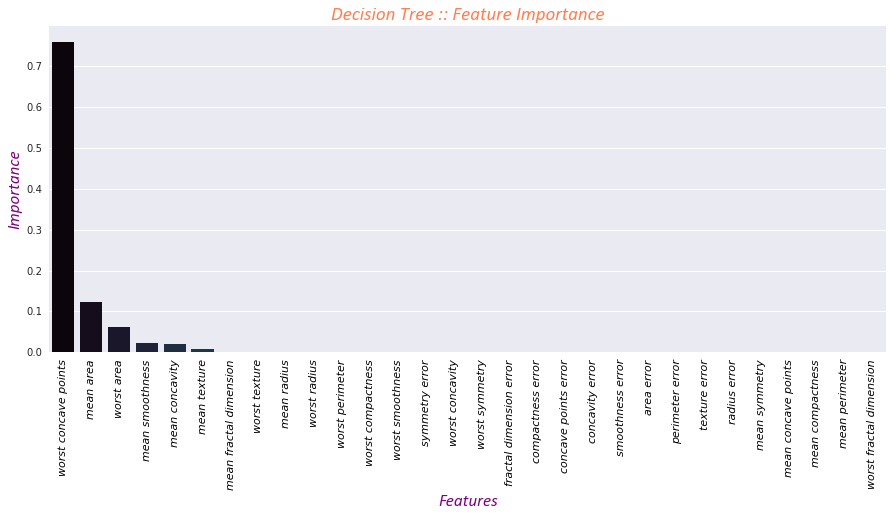

In [109]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(15,6))
    sns.barplot(data=dtc_most_imp_feats,x='Features',y='Importance',palette='cubehelix')
    plt.xticks(size=11,rotation=90,style='oblique',color='k')
    plt.xlabel(xlabel='Features', fontdict={'size':17,'family':'calibri','style':'oblique','color':'Purple'})
    plt.ylabel(ylabel='Importance', fontdict={'size':17,'family':'calibri','style':'oblique','color':'Purple'})
    plt.title(label="Decision Tree :: Feature Importance", fontdict={'size':19,'family':'calibri','style':'oblique','color':'coral'})

#### **So ,as per decision tree `worst concave points` is the most important feature for predicting the existence of cancer. Majority of features are having 0 score and it looks like model prediction is only relying on `worst concave points`.**

##### **Random_Forest :: Feature Importance**

In [110]:
rf_feat_imps = pd.DataFrame(rf.feature_importances_).T
rf_feat_imps.columns = lbc.feature_names
rf_feat_imps

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.060047,0.009819,0.061866,0.073146,0.005656,0.010204,0.067494,0.094105,0.002684,0.00469,0.015265,0.004668,0.011013,0.024227,0.0036,0.003829,0.004086,0.003891,0.002618,0.004066,0.076815,0.012141,0.092347,0.126083,0.008688,0.011488,0.028998,0.162597,0.010596,0.003272


In [111]:
rf_most_imp_feats = np.round(rf_feat_imps.T.sort_values(by=[0],axis=0,ascending=False).reset_index(drop=False),3)
rf_most_imp_feats.columns = ['Features','Importance']

In [112]:
np.sum(rf_most_imp_feats['Importance'])

1.001

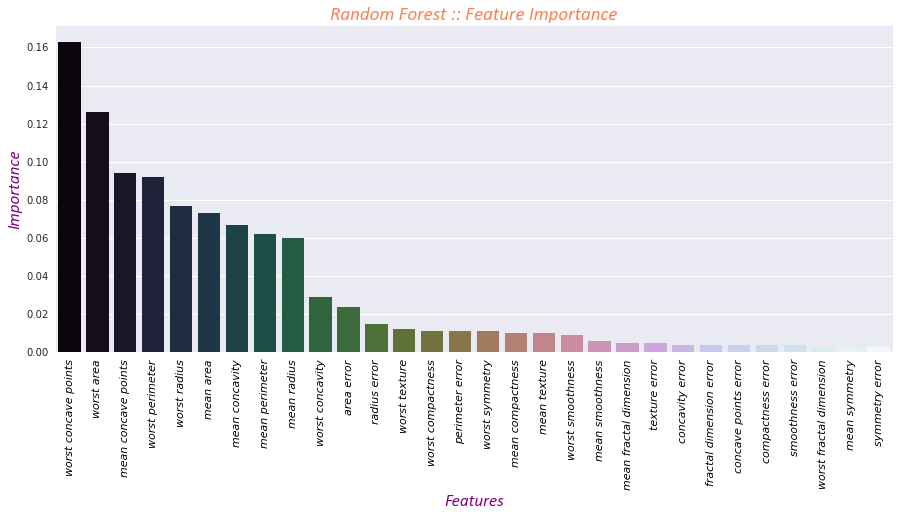

In [113]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(15,6))
    sns.barplot(data=rf_most_imp_feats,x='Features',y='Importance',palette='cubehelix')
    plt.xticks(size=11,rotation=90,style='oblique',color='k')
    plt.xlabel(xlabel='Features', fontdict={'size':17,'family':'calibri','style':'oblique','color':'Purple'})
    plt.ylabel(ylabel='Importance', fontdict={'size':17,'family':'calibri','style':'oblique','color':'Purple'})
    plt.title(label="Random Forest :: Feature Importance", fontdict={'size':19,'family':'calibri','style':'oblique','color':'coral'})

#### **So ,as per random forest `worst concave points` is also the most important feature for predicting the existence of cancer, but it is not the only feature which is playing role in prediction and some of the other features are also giving their equal input.**

In [114]:
shap.initjs()

In [115]:
dtc_shap_explainer = shap.TreeExplainer(dtc,
                                        data=X_train_cancer,
                                        feature_perturbation='interventional',
                                        model_output='probability')

In [116]:
dtc_shap_explainer.expected_value

array([0.418, 0.582])

In [117]:
dtc_shap_values = dtc_shap_explainer.shap_values(X_train_cancer)

In [118]:
c1 = pd.DataFrame(dtc_shap_values[0], columns = lbc.feature_names)
c1.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.0,0.012833,0.0,-0.046833,0.058667,0.0,0.130833,0.0,0.0,0.000500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002500,0.0,0.064167,0.0,0.0,0.0,0.364333,0.0,0.0
1,0.0,0.009333,0.0,-0.209000,-0.022667,0.0,0.002000,0.0,0.0,0.001333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011000,0.0,-0.117000,0.0,0.0,0.0,-0.071000,0.0,0.0
2,0.0,-0.026667,0.0,-0.157000,0.000000,0.0,-0.095333,0.0,0.0,0.001333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011000,0.0,0.000000,0.0,0.0,0.0,-0.129333,0.0,0.0
3,0.0,0.109000,0.0,0.527333,0.000000,0.0,0.003000,0.0,0.0,-0.001667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001667,0.0,0.000000,0.0,0.0,0.0,-0.054000,0.0,0.0
4,0.0,-0.026333,0.0,-0.158833,0.000000,0.0,0.003000,0.0,0.0,-0.003167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003167,0.0,0.000000,0.0,0.0,0.0,-0.229500,0.0,0.0


In [119]:
c2 = pd.DataFrame(dtc_shap_values[1], columns = lbc.feature_names)
c2.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.0,-0.012833,0.0,0.046833,-0.058667,0.0,-0.130833,0.0,0.0,-0.000500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002500,0.0,-0.064167,0.0,0.0,0.0,-0.364333,0.0,0.0
1,0.0,-0.009333,0.0,0.209000,0.022667,0.0,-0.002000,0.0,0.0,-0.001333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011000,0.0,0.117000,0.0,0.0,0.0,0.071000,0.0,0.0
2,0.0,0.026667,0.0,0.157000,0.000000,0.0,0.095333,0.0,0.0,-0.001333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011000,0.0,0.000000,0.0,0.0,0.0,0.129333,0.0,0.0
3,0.0,-0.109000,0.0,-0.527333,0.000000,0.0,-0.003000,0.0,0.0,0.001667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001667,0.0,0.000000,0.0,0.0,0.0,0.054000,0.0,0.0
4,0.0,0.026333,0.0,0.158833,0.000000,0.0,-0.003000,0.0,0.0,0.003167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003167,0.0,0.000000,0.0,0.0,0.0,0.229500,0.0,0.0


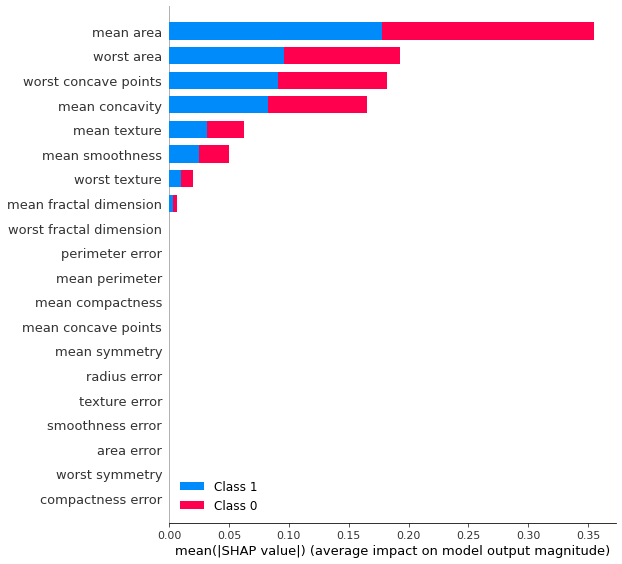

In [120]:
shap.summary_plot(dtc_shap_values,
                  features=X_train_cancer.columns,
                  plot_type='bar')

In [121]:
shap.plots.force(base_value=dtc_shap_explainer.expected_value[0],
                shap_values=dtc_shap_explainer.shap_values(X_train_cancer.iloc[6])[0],
                feature_names=X_train_cancer.columns
                )

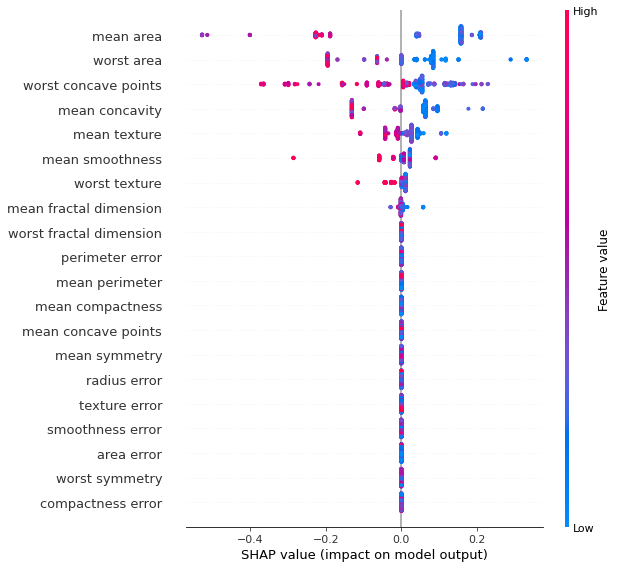

In [122]:
shap.summary_plot(dtc_shap_values[1],X_train_cancer)